In [2]:
import sys
sys.path.insert(0, '/liulab/alynch/projects/benchmarking_python/lib/python3.7/site-packages')
sys.path.insert(0, '/liulab/alynch/projects/multiomics/BatchEffect/MIRA')

import mira
assert mira.__file__ == '/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/__init__.py'

from frankencell.scaffold import check_definition, draw_graph, fill_scaffold, \
    draw_cells, format_dynverse_dataset, append_cell_info

from frankencell.mix import mix_expression
from frankencell.utils import add_dimred_prior, add_expression_to_dynframe, read_dynframe

import anndata
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from scipy import sparse
import numpy as np

In [4]:
!mkdir -p data/2022-08-26/
!mkdir -p data/2022-08-26/tests

In [5]:
generation_kwargs = dict(n_cells=2000, ptime_beta= 0.5, seed=2556, sigmoid_aggression=2)

test_kwargs = dict(
    rd_means = [1500],
    rd_stds = [0.35],
    pure_states = ['HSC', 'CD16+ Mono','B1 B', 'NK', 'CD8+ T','pDC','cDC2','G/M prog'],
    feature_types=['RNA'],
    cell_state_col='cell_type',
    n_jobs=5,
)


In [6]:
def make_graph(k):
    G = nx.DiGraph()
    G.add_node('HSC', mixing_weights = [1,0,0,0,0,0,0])
    G.add_node('1', mixing_weights = [0.5, 0.125, 0.125, 0.125, 0, 0.125,0])
    
    G.add_node('3', mixing_weights = [0.2, 0.4, 0, 0, 0, 0.4,0])
    G.add_node('Mono', mixing_weights = [0,1-k,0,0,0,k/2,k/2])
    G.add_node('pDC', mixing_weights = [0,k,0,0,0,(1-k)/2,(1-k)/2])
    
    
    G.add_node('2', mixing_weights = [0.2,0,0.4,0.4,0,0,0])
    G.add_node('B cell', mixing_weights = [0,0,1-k,k/2,k/2,0,0])
    G.add_node('NK', mixing_weights = [0,0,k,(1-k)/2,(1-k)/2,0,0])
    
    G.add_edge('HSC','1', weight = 1)
    G.add_edge('1','2', weight = 3)
    G.add_edge('1','3', weight = 2)
    G.add_edge('3','Mono', weight = 1)
    G.add_edge('3','pDC', weight = 1)
    G.add_edge('2','B cell', weight = 1)
    G.add_edge('2','NK', weight = 1)
    
    return G


def get_cell_info(G, NK_ratio, B_ratio, **generation_kwargs):
    
    wt_graph = G.copy()
    wt_graph.edges['2','NK']['weight'] = NK_ratio
    
    ko_graph = G.copy()
    ko_graph.edges['2','B cell']['weight'] = B_ratio
    
    wt_cell_info = fill_scaffold(wt_graph, 'HSC', **generation_kwargs)
    ko_cell_info = fill_scaffold(ko_graph, 'HSC', **generation_kwargs)
    
    return wt_cell_info, ko_cell_info

def generate_batched_perturbation(
    wt_refdata, ko_refdata, outfile,
    seed = 2556,
    k = 0.,
    NK_ratio = 0.,
    B_ratio = 0.,
    generation_kwargs = dict(),
    test_kwargs = dict(),
):
    G = make_graph(k)
    check_definition(G)

    wt_info, ko_info = get_cell_info(G, NK_ratio, B_ratio, **generation_kwargs)

    wt_expression, wt_feature_info = mix_frankencells(
        cell_info= wt_info,
        datasets = [wt_refdata],
        seed = seed,
        **test_kwargs
    )

    ko_expression, ko_feature_info = mix_frankencells(
        cell_info=ko_info,
        datasets = [ko_refdata],
        seed = seed + 1,
        **test_kwargs
    )

    assert wt_feature_info == ko_feature_info

    cell_info = append_cell_info(G, wt_info, ko_info)
    expression = sparse.vstack([wt_expression, ko_expression])

    format_dynverse_dataset(
        G = G, 
        cell_info = cell_info,
        feature_info = wt_feature_info, 
        expression = expression, 
        root_node = 'HSC', 
        output_path = outfile,
    )
    
    return G, cell_info, wt_feature_info, expression

def read_and_process(dynframe):
    
    testdata = read_dynframe(dynframe)
    
    sc.pp.filter_genes(testdata, min_cells = 15)
    testdata.raw = testdata

    sc.pp.normalize_total(testdata, target_sum=1e4)
    sc.pp.log1p(testdata)
    sc.pp.highly_variable_genes(testdata)

    testdata.layers['counts'] = testdata.raw.to_adata().X.copy()

    sc.pp.highly_variable_genes(testdata, min_disp=0)
    testdata.var['exog'] = testdata.var.highly_variable.copy()
    testdata.var['endog'] = (testdata.var.dispersions_norm > 0.5) & testdata.var.exog

    return testdata

In [22]:
X[0].nodes['NK']

{'mixing_weights': [0, 0, 0.15, 0.425, 0.425, 0, 0]}

In [23]:
X = generate_batched_perturbation(
    'data/datasets/s3d10_gex.h5ad', 
    'data/datasets/s4d1_gex.h5ad', 
    'data/2022-08-26/tests/0-0-0.h5',
    seed = 2556,
    k = 0.2,
    NK_ratio = 0.,
    B_ratio = 0.,
    generation_kwargs = generation_kwargs,
    test_kwargs = test_kwargs,
)

Stitching cells: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:54<00:00, 11.47it/s]
/liulab/alynch/projects/benchmarking_python/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:62: UserWarning:

Error while trying to convert the column "from". Fall back to string conversion. The error is: <class 'numpy.str_'>

/liulab/alynch/projects/benchmarking_python/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:62: UserWarning:

Error while trying to convert the column "to". Fall back to string conversion. The error is: <class 'numpy.str_'>



In [34]:
data = read_and_process('data/2022-08-26/tests/0-0-0.h5')

data.layers['sparse_counts'] = sparse.csr_matrix(data.layers['counts'])

model = mira.topics.TopicModel(
    *data.shape,
    feature_type='expression',
    endogenous_key='endog',
    exogenous_key='endog',
    counts_layer='sparse_counts',
    categorical_covariates='batch',
    cost_beta = 2.
)

model.get_learning_rate_bounds(data)

model.set_learning_rates(3e-3, 0.25)
#model.plot_learning_rate_bounds(figsize=(5,5))

t = mira.topics.Tracker()
model.set_params(num_topics = 6, decoder_dropout = 0.05, 
                 seed = 2556 + 22).fit(data, writer = t)

model.predict(data)

model.get_umap_features(data, box_cox=0.25)
sc.pp.neighbors(data, use_rep='X_umap_features', metric='manhattan')
sc.tl.umap(data, min_dist=0.1)

sc.pl.umap(data, color = ['mix_weight_' + str(i) for i in range(5)] + ['pseudotime', 'batch'],
          frameon=False)

sc.pl.umap(data, color = model.topic_cols, **mira.pref.topic_umap())

sc.pl.umap(data, color = 'batch', palette = ['cornflowerblue','lightgrey'], s= 50, alpha = 0.5,
          add_outline=True, frameon=False)

In [40]:
add_dimred_prior('data/2022-08-26/tests/0-0-0.h5', 
                 np.hstack([data.obsm['X_topic_compositions'].copy(), np.zeros((len(data), 1))]))

Calculating prior information using trajectory
Computing start milestones
Computing end milestones
Computing groups id
Computing groups network
Computing features id
Computing groups n
Computing start n
Computing end n
Computing end n
Computing timecourse continuous
Computing timecourse discrete


In [41]:
!mkdir -p data/2022-08-26/mira/

In [32]:
!./frankencell-dynverse/franken-cells-yaml evaluate test.yaml

Executing 'mira' on '20220827_092053__data_wrapper__yLYoU2L92K'
With parameters: list(threshold = 1, tune = TRUE, n_neighbors = 30L, metric = "manhattan",     use_rep = "RNA", box_cox = 0.5, are_topic_compositions = TRUE,     ka = 5L)
inputs: counts
priors : start_id, end_id, dimred
Input saved to /tmp/Rtmpd5ez8x/file35aea40283129/ti
Running ./run --dataset input.h5 --output output.h5
INFO:root:Added key to obsm: X_diffmap, normalized diffmap with 8 components.
INFO:root:Added key to uns: eigen_gap
INFO:mira.pseudotime.pseudotime:Found 1 components of KNN graph.
INFO:mira.adata_interface.core:Added cols to obs: mira_connected_components
    Number of diffusion components (n_pcs) to use while calculating diffusion KNN graph was not set.
    This is new as of version 0.1.1. When calculating a diffusion KNN graph following 
        
        sc.tl.diffmap(adata)
        mira.time.normalize_diffmap(adata)

    You can check for the optimal number of diffusion components to use by:

        

In [33]:
!cat data/2022-08-26/mira/results.tsv

time_waypointedgeodesic	6.56214308738708
correlation	0.910855418521134
time_correlation	0.786017417907715
edge_flip	1
time_edge_flip	0.0506060123443604
time_mapping_branches	1.41245412826538
recovery_branches	0.631321711779342
relevance_branches	0.631321711779342
F1_branches	0.631321711779342


tuner = mira.topics.SpeedyTuner(
    model = model,
    min_topics = 3, 
    max_topics=15,
    save_name = 'frank/2022-08-26/tests/0',
    min_trials=32,
    max_trials=60,
    n_jobs=5,
    seed = 2556,
)

tuner.fit(data)

In [18]:
data.write_h5ad('data/temp.h5ad')

/liulab/alynch/projects/benchmarking_python/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning:

The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.

... storing 'feature_type' as categorical


In [19]:
import sys
sys.path.insert(0, '/liulab/alynch/projects/multiomics/BatchEffect/MIRA')

import mira
assert mira.__file__ == '/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/__init__.py'
import anndata
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from scipy import sparse
import numpy as np
import scvi

ModuleNotFoundError: No module named 'scvi'

In [2]:
def scvi(adata, batch, hvg=None, return_model=False, max_epochs=None):
    
    try:
        from scvi.model import SCVI
    except ModuleNotFoundError as e:
        raise IntegrationMethodNotFound(e)

    #utils.check_sanity(adata, batch, hvg)

    # Check for counts data layer
    if "counts" not in adata.layers:
        raise TypeError(
            "Adata does not contain a `counts` layer in `adata.layers[`counts`]`"
        )

    # Defaults from SCVI github tutorials scanpy_pbmc3k and harmonization
    n_latent = 4
    n_hidden = 64
    n_layers = 1

    # copying to not return values added to adata during setup_anndata
    net_adata = adata.copy()
    if hvg is not None:
        net_adata = adata[:, hvg].copy()
    SCVI.setup_anndata(net_adata, layer="counts", batch_key=batch)

    vae = SCVI(
        net_adata,
        gene_likelihood="nb",
        n_layers=n_layers,
        n_latent=n_latent,
        n_hidden=n_hidden,
    )
    vae.train(train_size=1.0, max_epochs=max_epochs)
    adata.obsm["X_emb"] = vae.get_latent_representation()

    if not return_model:
        return adata
    else:
        return vae

In [3]:
data = anndata.read_h5ad('data/temp.h5ad')

In [4]:
data = scvi(data[:, data.var.endog], 'batch')

INFO:absl:Remote TPU is not linked into jax; skipping remote TPU.
INFO:absl:Unable to initialize backend 'tpu_driver': Could not initialize backend 'tpu_driver'
INFO:absl:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:absl:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:absl:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmppyc_b508
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmppyc_b508/_remote_module_non_scriptable.py
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, 

Epoch 400/400: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [04:48<00:00,  1.39it/s, loss=686, v_num=1]


In [5]:
sc.pp.neighbors(data, use_rep='X_emb')
sc.tl.umap(data, min_dist=0.1)

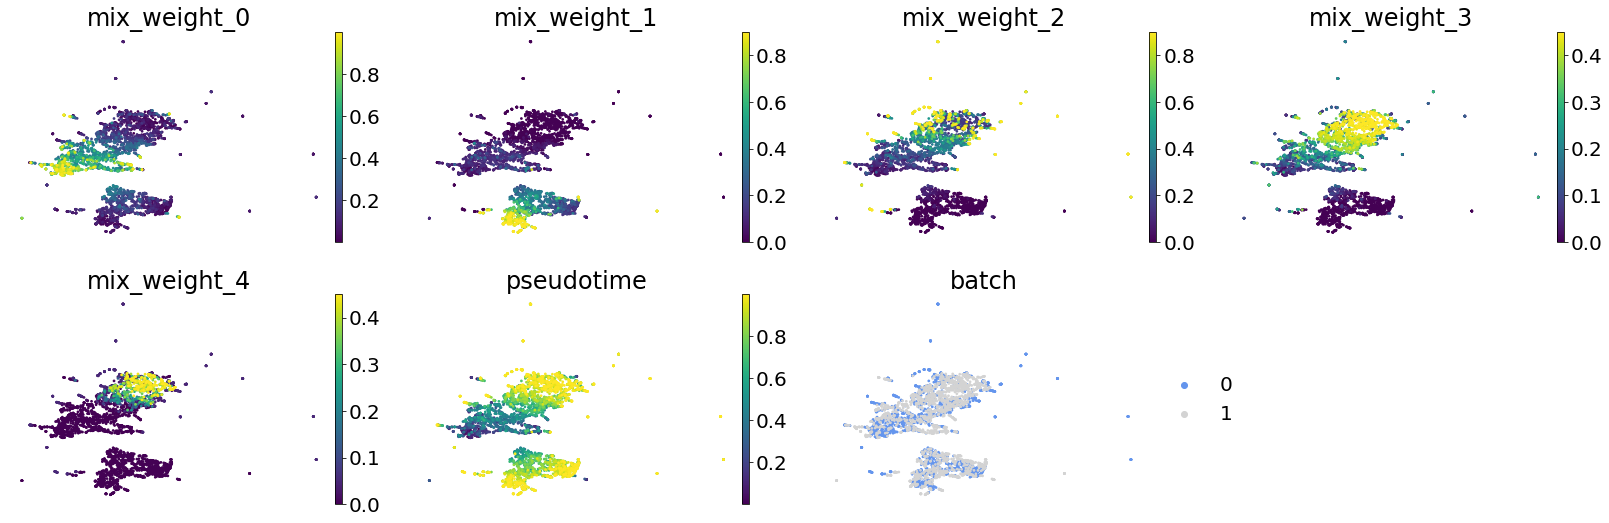

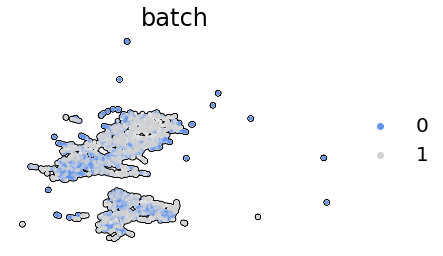

In [6]:
sc.pl.umap(data, color = ['mix_weight_' + str(i) for i in range(5)] + ['pseudotime', 'batch'],
          frameon=False)

sc.pl.umap(data, color = 'batch', palette = ['cornflowerblue','lightgrey'], s= 50, alpha = 0.5,
          add_outline=True, frameon=False)